In [1]:
# libraries
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
# data
from data.data import data
from data.sys_data import sys_data 

# setup
sns.set_theme()

In [2]:
# get data
raw_dataset = data.parse_data('../report.txt')
df = pd.DataFrame(raw_dataset)

print("Peak Bandwidth: ", sys_data.peak_theoretical_bandwidth, "GB/s")
print(raw_dataset)

Peak Bandwidth:  42.94967296 GB/s
                     name          time   space
0                    loop  3.826840e-07     100
1                    loop  3.729910e-06    1000
2                    loop  3.321170e-05   10000
3                    loop  3.279180e-04  100000
4         vectorized_loop  3.098720e-07     100
5         vectorized_loop  2.911590e-06    1000
6         vectorized_loop  2.752680e-05   10000
7         vectorized_loop  2.722990e-04  100000
8          write and read  3.841610e-07     400
9          write and read  3.522110e-06    4000
10         write and read  3.491610e-05   40000
11         write and read  1.748780e-04  200000
12         write and read  3.502190e-04  400000
13           write serial  1.853020e-07     100
14           write serial  1.602510e-06    1000
15           write serial  1.562740e-05   10000
16           write serial  7.765430e-05   50000
17           write serial  1.560070e-04  100000
18           write random  2.448900e-07     100
19    

# Write and Read

In [3]:
df_bandwidth = df.loc[df.name =='write and read'].copy()
df_bandwidth['bandwidth'] = \
    df_bandwidth.apply(lambda row: \
        data.effective_bandwidth(row.space, row.time, True) / 1e9, \
    axis=1 \
    )
print(df_bandwidth)

              name          time   space  bandwidth
8   write and read  3.841610e-07     400   2.082460
9   write and read  3.522110e-06    4000   2.271366
10  write and read  3.491610e-05   40000   2.291207
11  write and read  1.748780e-04  200000   2.287309
12  write and read  3.502190e-04  400000   2.284285


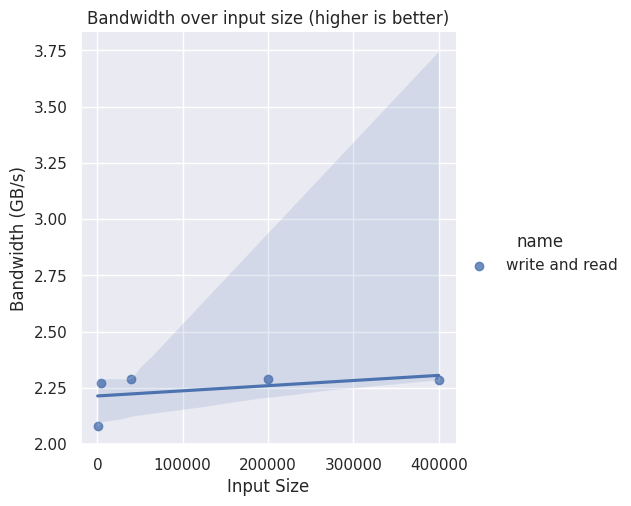

In [4]:
sns.lmplot(
    data=df_bandwidth, hue='name', 
    x="space", y="bandwidth",
)
plt.title('Bandwidth over input size (higher is better)')
plt.xlabel('Input Size')
plt.ylabel('Bandwidth (GB/s)')
plt.show()

# Float sum

In [5]:
df_flops = df.loc[df.name == 'float sum'].copy()
df_flops['bandwidth'] = \
    df_flops.apply(lambda row: \
        data.effective_bandwidth(row.space * 4, row.time, True) / 1e9, \
    axis=1 \
    )
print(df_flops)

         name          time   space  bandwidth
23  float sum  2.820720e-07     100   2.836155
24  float sum  2.655650e-06    1000   3.012445
25  float sum  2.565980e-05   10000   3.117717
26  float sum  1.244820e-04   50000   3.213316
27  float sum  2.445640e-04  100000   3.271127


In [6]:
# insert max teoretical bandwidth
df_max = pd.DataFrame({
    'name': [f'theoretical max' for space in df_flops.space.unique()],
    'space': df_flops.space.unique(),
    'bandwidth': sys_data.peak_theoretical_bandwidth # Calculate theoretical max bandwidth
})
df_final = pd.concat([df_flops, df_max])
print(df_final)

               name          time   space  bandwidth
23        float sum  2.820720e-07     100   2.836155
24        float sum  2.655650e-06    1000   3.012445
25        float sum  2.565980e-05   10000   3.117717
26        float sum  1.244820e-04   50000   3.213316
27        float sum  2.445640e-04  100000   3.271127
0   theoretical max           NaN     100  42.949673
1   theoretical max           NaN    1000  42.949673
2   theoretical max           NaN   10000  42.949673
3   theoretical max           NaN   50000  42.949673
4   theoretical max           NaN  100000  42.949673


Text(62.01787500000002, 0.5, 'Bandwidth (GB/s)')

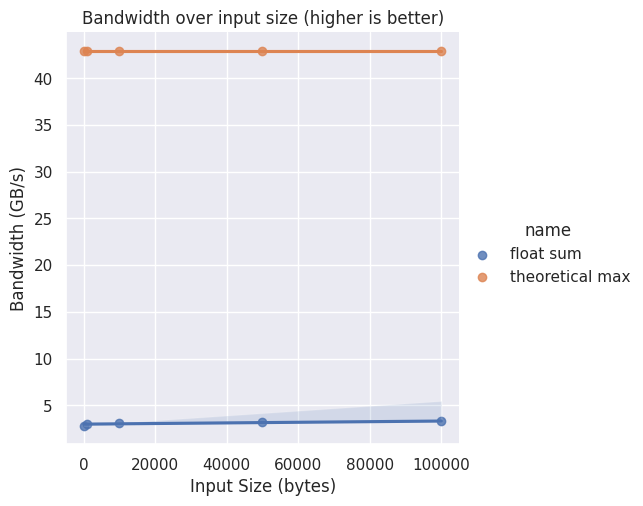

In [7]:
sns.lmplot(
    data=df_final, hue='name', 
    x="space", y="bandwidth",
)
plt.title('Bandwidth over input size (higher is better)')
plt.xlabel('Input Size (bytes)')
plt.ylabel('Bandwidth (GB/s)')

         name          time   space         flops
23  float sum  2.820720e-07     100  3.545194e+08
24  float sum  2.655650e-06    1000  3.765556e+08
25  float sum  2.565980e-05   10000  3.897147e+08
26  float sum  1.244820e-04   50000  4.016645e+08
27  float sum  2.445640e-04  100000  4.088909e+08


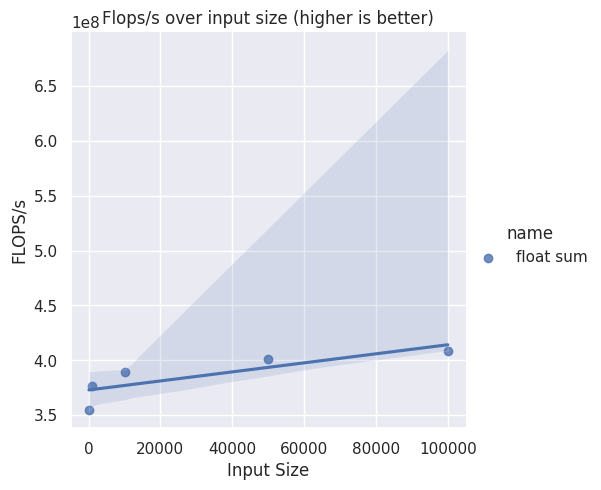

In [8]:
df_flops = df.loc[df.name == 'float sum'].copy()
df_flops['flops'] = \
    df_flops.apply(\
        lambda row: \
            data.flopss(row.space, row.time), \
        axis=1 \
    )
print(df_flops)

sns.lmplot(
    data=df_flops, hue='name', 
    x="space", y="flops",
)
plt.title('Flops/s over input size (higher is better)')
plt.xlabel('Input Size')
plt.ylabel('FLOPS/s')
plt.show()

# Sequencial vs Random write

In [9]:
df_sequencial = df.loc[df.name.isin(['write serial', 'write random'])].copy()
# multiply the space by sizeof(int) and by two because we are doing reads and writes
df_sequencial['bandwidth'] = \
    df_sequencial.apply(\
        lambda row: \
            data.effective_bandwidth(row.space * 4 * 2, row.time, True) / 1e9, \
        axis=1, \
    )
print(df_sequencial)

            name          time   space  bandwidth
13  write serial  1.853020e-07     100   8.634553
14  write serial  1.602510e-06    1000   9.984337
15  write serial  1.562740e-05   10000  10.238427
16  write serial  7.765430e-05   50000  10.302070
17  write serial  1.560070e-04  100000  10.255950
18  write random  2.448900e-07     100   6.533546
19  write random  2.340650e-06    1000   6.835708
20  write random  2.170370e-05   10000   7.372015
21  write random  1.075970e-04   50000   7.435152
22  write random  2.134860e-04  100000   7.494637


In [10]:
# insert max teoretical bandwidth
df_max = pd.DataFrame({
    'name': ['theoretical max' for space in df_sequencial.space.unique()],
    'space': df_sequencial.space.unique(),
    'bandwidth': sys_data.peak_theoretical_bandwidth # Calculate theoretical max bandwidth
})
df_sequencial = pd.concat([df_sequencial, df_max])
print(df_sequencial)

               name          time   space  bandwidth
13     write serial  1.853020e-07     100   8.634553
14     write serial  1.602510e-06    1000   9.984337
15     write serial  1.562740e-05   10000  10.238427
16     write serial  7.765430e-05   50000  10.302070
17     write serial  1.560070e-04  100000  10.255950
18     write random  2.448900e-07     100   6.533546
19     write random  2.340650e-06    1000   6.835708
20     write random  2.170370e-05   10000   7.372015
21     write random  1.075970e-04   50000   7.435152
22     write random  2.134860e-04  100000   7.494637
0   theoretical max           NaN     100  42.949673
1   theoretical max           NaN    1000  42.949673
2   theoretical max           NaN   10000  42.949673
3   theoretical max           NaN   50000  42.949673
4   theoretical max           NaN  100000  42.949673


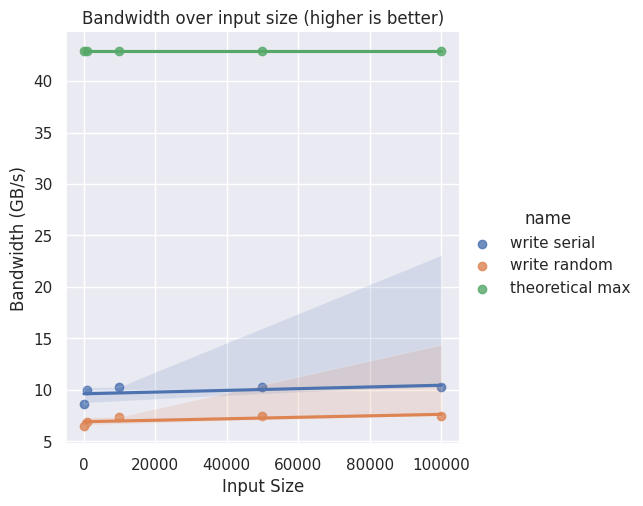

In [11]:
sns.lmplot(
    data=df_sequencial, hue='name', 
    x="space", y="bandwidth",
)
plt.title('Bandwidth over input size (higher is better)')
plt.xlabel('Input Size')
plt.ylabel('Bandwidth (GB/s)')
plt.show()

# Matrix Multiplication

In [12]:
df_mmul = df.loc[df.name == 'matrix multiplication'].copy()
df_mmul['bandwidth'] = \
    df_mmul.apply(\
        lambda row: \
            data.effective_bandwidth(row.space**2 *4, row.time, True) / 1e9, \
        axis=1, \
    )
print(df_mmul)

                     name      time  space  bandwidth
28  matrix multiplication  0.000004     10   0.210647
29  matrix multiplication  0.000055     25   0.091662
30  matrix multiplication  0.000417     50   0.047955
31  matrix multiplication  0.001309     75   0.034373
32  matrix multiplication  0.003117    100   0.025664


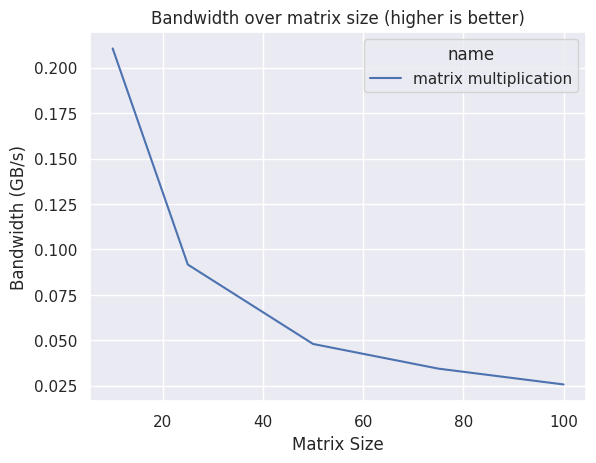

In [13]:
sns.lineplot(
    data=df_mmul, hue='name', 
    x="space", y="bandwidth",
)
plt.title('Bandwidth over matrix size (higher is better)')
plt.xlabel('Matrix Size')
plt.ylabel('Bandwidth (GB/s)')
plt.show()

In [14]:
df_mmul_flops = df.loc[df.name == 'matrix multiplication'].copy()
df_mmul_flops['flops'] = \
    df_mmul_flops.apply(\
        lambda row: \
            data.flopss(row.space**2 * 2, row.time),
        axis=1, \
    )
df_mmul_flops.space = \
    df_mmul_flops.apply(\
        lambda row: \
            row.flops / (row.space**3 * 4), \
        axis=1,\
    )
print(df_mmul_flops)

                     name      time         space         flops
28  matrix multiplication  0.000004  13165.412881  5.266165e+07
29  matrix multiplication  0.000055    366.646196  2.291539e+07
30  matrix multiplication  0.000417     23.977308  1.198865e+07
31  matrix multiplication  0.001309      5.092363  8.593362e+06
32  matrix multiplication  0.003117      1.604009  6.416035e+06


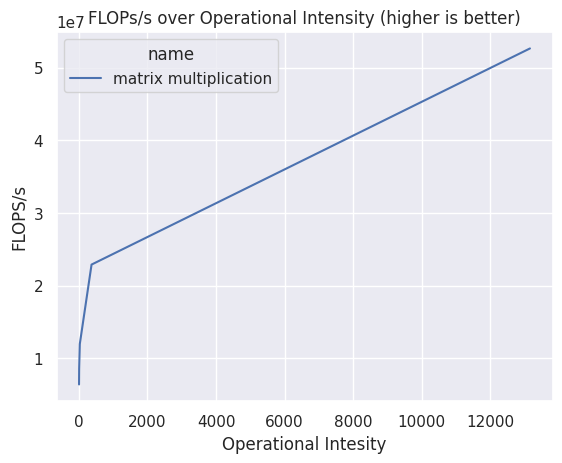

In [15]:
sns.lineplot(
    data=df_mmul_flops, hue='name', 
    x="space", y="flops",
)
plt.title('FLOPs/s over Operational Intensity (higher is better)')
plt.xlabel('Operational Intesity')
plt.ylabel('FLOPS/s')
plt.show()

In [16]:
df_mmul_flops = df.loc[df.name == 'matrix multiplication'].copy()
df_mmul_flops['flops'] = \
    df_mmul_flops.apply(\
        lambda row: \
            data.flopss(row.space**3 * 2, row.time),
        axis=1, \
    )
df_mmul_flops.space = \
    df_mmul_flops.apply(\
        lambda row: \
            row.space **2 * 4, \
        axis=1,\
    )
print(df_mmul_flops)

                     name      time  space         flops
28  matrix multiplication  0.000004    400  5.266165e+08
29  matrix multiplication  0.000055   2500  5.728847e+08
30  matrix multiplication  0.000417  10000  5.994327e+08
31  matrix multiplication  0.001309  22500  6.445022e+08
32  matrix multiplication  0.003117  40000  6.416035e+08


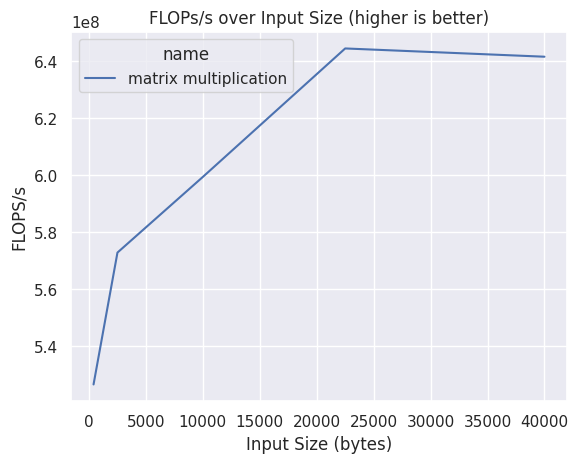

In [17]:
sns.lineplot(
    data=df_mmul_flops, hue='name', 
    x="space", y="flops",
)
plt.title('FLOPs/s over Input Size (higher is better)')
plt.xlabel('Input Size (bytes)')
plt.ylabel('FLOPS/s')
plt.show()